In [1]:
from __future__ import absolute_import
from __future__ import division
from __future__ import print_function

import argparse
import sys

from tensorflow.examples.tutorials.mnist import input_data
import tensorflow as tf
import numpy as np

In [2]:
batch_size = 100
img_sz = 28
img_len = img_sz*img_sz
n_itr = 10000
n_class = 10
lstm_size = 256
T = 10
A = img_sz
B = img_sz
eps = 1e-7
N = 5

In [3]:
# calculate F_x and F_y
def get_Fx_Fy(h):
    params = tf.matmul(h, params_W) + params_b
    g_x_, g_y_, log_var_Fxy, log_delta_, log_gamma = tf.split(params, num_or_size_splits=5, axis=1)
    var_Fxy = tf.exp(log_var_Fxy)
    gamma = tf.exp(log_gamma)
    
    g_x = ((A + 1) * 0.5) * (g_x_ + 1)
    g_y = ((B + 1) * 0.5) * (g_y_ + 1)
    delta = ((max(A, B) - 1) / (N - 1)) * tf.exp(log_delta_)

    filter_i = tf.reshape(tf.cast(tf.range(N), tf.float32), [1, -1])
    mu_x = g_x + (filter_i - N / 2 - 0.5) * delta
    mu_y = g_y + (filter_i - N / 2 - 0.5) * delta

    a = tf.reshape(tf.cast(tf.range(A), tf.float32), [1, 1, -1])
    b = tf.reshape(tf.cast(tf.range(B), tf.float32), [1, 1, -1])
    mu_x = tf.reshape(mu_x, [-1, N, 1])
    mu_y = tf.reshape(mu_y, [-1, N, 1])
    var_Fxy = tf.reshape(var_Fxy, [-1, 1, 1])    
    
    F_x = tf.exp(-tf.square((a - mu_x) / (2 * var_Fxy)))
    F_y = tf.exp(-tf.square((b - mu_y) / (2 * var_Fxy))) 
    
    F_x = F_x / tf.maximum(tf.reduce_sum(F_x, 2, keep_dims=True), eps)
    F_y = F_y / tf.maximum(tf.reduce_sum(F_y, 2, keep_dims=True), eps)
    return (F_x, F_y, gamma)

In [4]:
def read(r, F_x, F_y, gamma):
    # (F_x.T r F_y) * gamma
    r = tf.reshape(r, [-1, B, A])
    F_x_transpose = tf.transpose(F_x, perm=[0,2,1])
    r = tf.matmul(F_y, tf.matmul(r, F_x_transpose))
    r = tf.reshape(r, [-1, N*N])
    r = r * tf.reshape(gamma,[-1,1])
    return r

In [5]:
def write(w, F_x, F_y, gamma):
    # (F_y.T w_ F_x) / gamma
    w = tf.reshape(w, [batch_size, N, N])
    F_y_transpose = tf.transpose(F_y, perm=[0,2,1])
    w = tf.matmul(F_y_transpose, tf.matmul(w, F_x))
    w = tf.reshape(w, [batch_size, B*A])
    w = w * tf.reshape(1.0/gamma,[-1,1])
    return w

In [6]:
x = tf.placeholder(tf.float32, [batch_size, img_len])
y_ = tf.placeholder(tf.float32, [batch_size, n_class])

rnn_enc = tf.contrib.rnn.LSTMCell(lstm_size)
rnn_dec = tf.contrib.rnn.LSTMCell(lstm_size)

write_W = tf.Variable(tf.zeros([lstm_size, N*N]))
write_b = tf.Variable(tf.zeros([N*N]))

mu_W = tf.Variable(tf.zeros([lstm_size, n_class]))
mu_b = tf.Variable(tf.zeros([n_class]))


# learnable params for tau
#log_tau_W = tf.Variable(tf.zeros([lstm_size, n_class]))
#log_tau_b = tf.Variable(tf.zeros([n_class]))

params_W = tf.Variable(tf.zeros([lstm_size, 5]))
params_b = tf.Variable(tf.zeros([5]))

lr = tf.placeholder(tf.float32, shape=[])
tau = tf.placeholder(tf.float32, shape=[])

In [7]:
c = [0]*T
state_dec = rnn_dec.zero_state(batch_size, tf.float32) 
# read
for t in range(T):
    # Gumbol softmax distribution
    U = tf.random_uniform([batch_size, n_class],minval=0,maxval=1)
    # get gumble(0, 1) sample
    G = -tf.log(-tf.log(U + eps) + eps)
    # gubmle(logits, 1) sample
    z_sample = G
    # softmax approximation of one hot (categorical) distrubution
    #z_sfmx = tf.nn.softmax(z_sample / tau_Q)
    z_sfmx = tf.nn.softmax(z_sample / tau)
    
    # get the one hot encoding
    z_one_hot = tf.cast(tf.equal(z_sfmx, tf.reduce_max(z_sfmx, 1, keep_dims=True)), z_sfmx.dtype)
    
    # staright through cat. distr.
    # we need one hot encoding as output (z_one_hot)
    # but gradient on z_sfmx
    diff = tf.stop_gradient(z_one_hot - z_sfmx) 
    # zero gradient flow through this diff varibale 
    # affectively making variable diff a constant
    # so gradient flow through z is same as z_sfmx
    z = diff + z_sfmx
                   
    # decoder
    with tf.variable_scope("decoder", reuse=(t != 0)):
        h_dec, state_dec = rnn_dec(z, state_dec) 
    
    # no atten
    w = tf.matmul(h_dec, write_W) + write_b
        
    #write       
    F_x, F_y, gamma = get_Fx_Fy(h_dec)
    w = write(w, F_x, F_y, gamma)
    
    c_prev = tf.zeros([batch_size, img_len]) if t==0 else c[t-1]
    c[t] = c_prev + w

In [8]:
tau0 = 1.0
tau_val = tau0
anneal_rate = 0.00003
min_temp = 0.5
lr_val = 1e-3 

In [9]:
sess = tf.InteractiveSession()
saver = tf.train.Saver()
ckpt_file= "saved_models/draw_model_gambol_sfmx.ckpt"

saver.restore(sess, ckpt_file)
print("Model restored")

NotFoundError: Key decoder/lstm_cell/weights not found in checkpoint
	 [[Node: save/RestoreV2_7 = RestoreV2[dtypes=[DT_FLOAT], _device="/job:localhost/replica:0/task:0/cpu:0"](_recv_save/Const_0, save/RestoreV2_7/tensor_names, save/RestoreV2_7/shape_and_slices)]]

Caused by op u'save/RestoreV2_7', defined at:
  File "/Users/kumaratul/anaconda2/lib/python2.7/runpy.py", line 162, in _run_module_as_main
    "__main__", fname, loader, pkg_name)
  File "/Users/kumaratul/anaconda2/lib/python2.7/runpy.py", line 72, in _run_code
    exec code in run_globals
  File "/Users/kumaratul/anaconda2/lib/python2.7/site-packages/ipykernel/__main__.py", line 3, in <module>
    app.launch_new_instance()
  File "/Users/kumaratul/anaconda2/lib/python2.7/site-packages/traitlets/config/application.py", line 653, in launch_instance
    app.start()
  File "/Users/kumaratul/anaconda2/lib/python2.7/site-packages/ipykernel/kernelapp.py", line 474, in start
    ioloop.IOLoop.instance().start()
  File "/Users/kumaratul/anaconda2/lib/python2.7/site-packages/zmq/eventloop/ioloop.py", line 162, in start
    super(ZMQIOLoop, self).start()
  File "/Users/kumaratul/anaconda2/lib/python2.7/site-packages/tornado/ioloop.py", line 887, in start
    handler_func(fd_obj, events)
  File "/Users/kumaratul/anaconda2/lib/python2.7/site-packages/tornado/stack_context.py", line 275, in null_wrapper
    return fn(*args, **kwargs)
  File "/Users/kumaratul/anaconda2/lib/python2.7/site-packages/zmq/eventloop/zmqstream.py", line 440, in _handle_events
    self._handle_recv()
  File "/Users/kumaratul/anaconda2/lib/python2.7/site-packages/zmq/eventloop/zmqstream.py", line 472, in _handle_recv
    self._run_callback(callback, msg)
  File "/Users/kumaratul/anaconda2/lib/python2.7/site-packages/zmq/eventloop/zmqstream.py", line 414, in _run_callback
    callback(*args, **kwargs)
  File "/Users/kumaratul/anaconda2/lib/python2.7/site-packages/tornado/stack_context.py", line 275, in null_wrapper
    return fn(*args, **kwargs)
  File "/Users/kumaratul/anaconda2/lib/python2.7/site-packages/ipykernel/kernelbase.py", line 276, in dispatcher
    return self.dispatch_shell(stream, msg)
  File "/Users/kumaratul/anaconda2/lib/python2.7/site-packages/ipykernel/kernelbase.py", line 228, in dispatch_shell
    handler(stream, idents, msg)
  File "/Users/kumaratul/anaconda2/lib/python2.7/site-packages/ipykernel/kernelbase.py", line 390, in execute_request
    user_expressions, allow_stdin)
  File "/Users/kumaratul/anaconda2/lib/python2.7/site-packages/ipykernel/ipkernel.py", line 196, in do_execute
    res = shell.run_cell(code, store_history=store_history, silent=silent)
  File "/Users/kumaratul/anaconda2/lib/python2.7/site-packages/ipykernel/zmqshell.py", line 501, in run_cell
    return super(ZMQInteractiveShell, self).run_cell(*args, **kwargs)
  File "/Users/kumaratul/anaconda2/lib/python2.7/site-packages/IPython/core/interactiveshell.py", line 2717, in run_cell
    interactivity=interactivity, compiler=compiler, result=result)
  File "/Users/kumaratul/anaconda2/lib/python2.7/site-packages/IPython/core/interactiveshell.py", line 2821, in run_ast_nodes
    if self.run_code(code, result):
  File "/Users/kumaratul/anaconda2/lib/python2.7/site-packages/IPython/core/interactiveshell.py", line 2881, in run_code
    exec(code_obj, self.user_global_ns, self.user_ns)
  File "<ipython-input-9-4068cfe9cca3>", line 2, in <module>
    saver = tf.train.Saver()
  File "/Users/kumaratul/anaconda2/lib/python2.7/site-packages/tensorflow/python/training/saver.py", line 1040, in __init__
    self.build()
  File "/Users/kumaratul/anaconda2/lib/python2.7/site-packages/tensorflow/python/training/saver.py", line 1070, in build
    restore_sequentially=self._restore_sequentially)
  File "/Users/kumaratul/anaconda2/lib/python2.7/site-packages/tensorflow/python/training/saver.py", line 675, in build
    restore_sequentially, reshape)
  File "/Users/kumaratul/anaconda2/lib/python2.7/site-packages/tensorflow/python/training/saver.py", line 402, in _AddRestoreOps
    tensors = self.restore_op(filename_tensor, saveable, preferred_shard)
  File "/Users/kumaratul/anaconda2/lib/python2.7/site-packages/tensorflow/python/training/saver.py", line 242, in restore_op
    [spec.tensor.dtype])[0])
  File "/Users/kumaratul/anaconda2/lib/python2.7/site-packages/tensorflow/python/ops/gen_io_ops.py", line 668, in restore_v2
    dtypes=dtypes, name=name)
  File "/Users/kumaratul/anaconda2/lib/python2.7/site-packages/tensorflow/python/framework/op_def_library.py", line 763, in apply_op
    op_def=op_def)
  File "/Users/kumaratul/anaconda2/lib/python2.7/site-packages/tensorflow/python/framework/ops.py", line 2327, in create_op
    original_op=self._default_original_op, op_def=op_def)
  File "/Users/kumaratul/anaconda2/lib/python2.7/site-packages/tensorflow/python/framework/ops.py", line 1226, in __init__
    self._traceback = _extract_stack()

NotFoundError (see above for traceback): Key decoder/lstm_cell/weights not found in checkpoint
	 [[Node: save/RestoreV2_7 = RestoreV2[dtypes=[DT_FLOAT], _device="/job:localhost/replica:0/task:0/cpu:0"](_recv_save/Const_0, save/RestoreV2_7/tensor_names, save/RestoreV2_7/shape_and_slices)]]


In [12]:
output_images = sess.run(c, feed_dict={tau:min_temp}) 
output_images = np.array(output_images) 

out_file="draw_data_gubl_stochastic.npy"
np.save(out_file,[output_images])
print("Outputs saved in file: %s" % out_file)

sess.close()

Outputs saved in file: draw_data_gubl_stochastic.npy


In [13]:
import matplotlib
import sys
import numpy as np

import matplotlib.pyplot as plt

%matplotlib inline

def xrecons_grid(X,B,A):
    padsize=1
    padval=.5
    ph=B+2*padsize
    pw=A+2*padsize
    batch_size=X.shape[0]
    N=int(np.sqrt(batch_size))
    X=X.reshape((N,N,B,A))
    img=np.ones((N*ph,N*pw))*padval
    for i in range(N):
        for j in range(N):
            startr=i*ph+padsize
            endr=startr+B
            startc=j*pw+padsize
            endc=startc+A
            img[startr:endr,startc:endc]=X[i,j,:,:]
    return img

In [15]:
out_file="draw_data_gubl_stochastic.npy"
[C]=np.load(out_file)
T,batch_size,img_size=C.shape
X=1.0/(1.0+np.exp(-C)) 
B=A=int(np.sqrt(img_size))


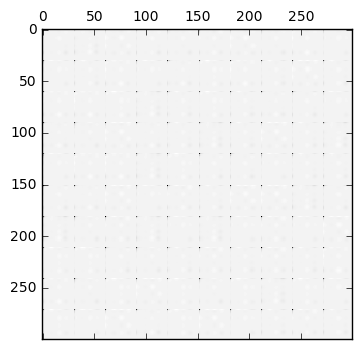

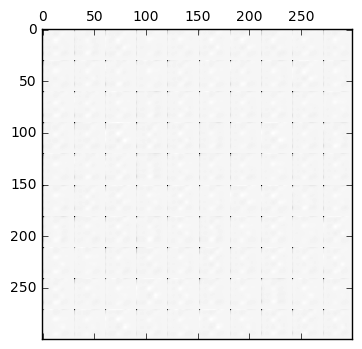

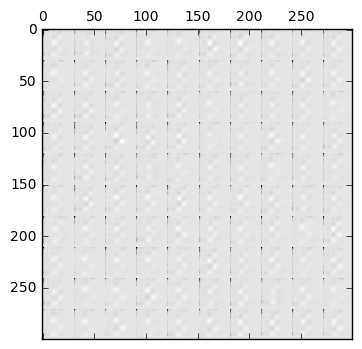

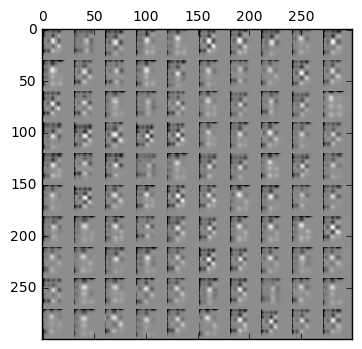

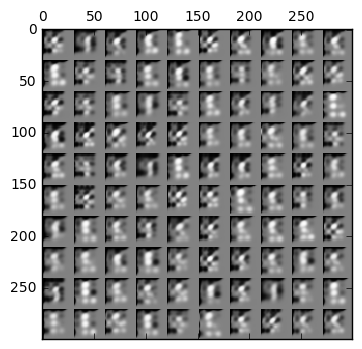

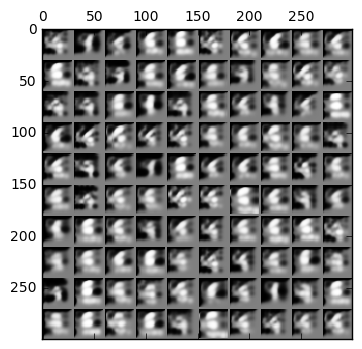

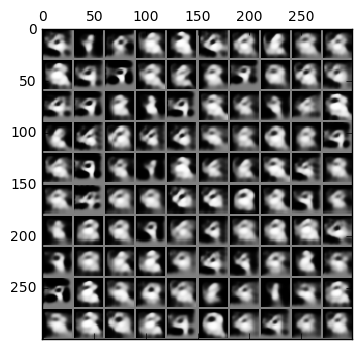

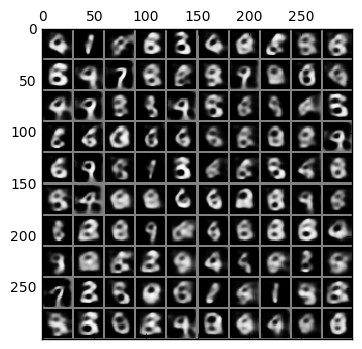

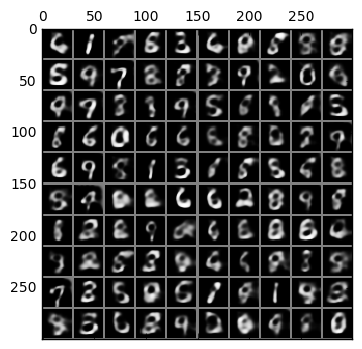

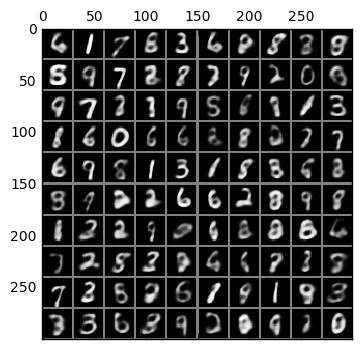

In [16]:
for t in range(T):
    img=xrecons_grid(X[t,:,:],B,A)
    plt.matshow(img,cmap=plt.cm.gray)
    ## convert -delay 10 -loop 0 *.png mnist.gif
    #imgname='img_%d.png' % ('images', t) 
    #plt.savefig(imgname)
    #print(imgname)
